In [ ]:
# Sanity check
import platform
platform.node()

: 

In [2]:
import os, sys, glob, json, argparse, time
sys.path.append('../')

import torch as th
from transformers import set_seed
from tqdm import tqdm
from functools import partial

from diffuseq.utils import dist_util
from diffuseq.text_datasets import load_data_text
from diffuseq.rounding import denoised_fn_round
from basic_utils import (
    load_defaults_config,
    create_model_and_diffusion,
    add_dict_to_argparser,
    args_to_dict,
    load_tokenizer
)

In [3]:
seed = 102

model_dir = "/srv/nlprx-lab/share6/dheineman3/diffusion/DiffuSeq/diffusion_models/"
# model_name = "diffuseq_dialogue_h128_lr0.0001_t2000_sqrt_lossaware_seed102_ts20230310-12:47:26"
model_name = "diffuseq_dialogue_h128_lr0.0001_t2000_sqrt_lossaware_seed102_ts20230402-13:09:56"
model_path = model_dir + model_name
out_dir = 'generation_outputs'

# Get last checkpoint
checkpoints = sorted(glob.glob(f"{model_path}/ema*.pt"))[::-1]
checkpoint_path = checkpoints[0]

# Load model config (add default values if they don't exist)
config_path = f"{model_path}/training_args.json"
args = load_defaults_config()
with open(config_path, 'rb', ) as f:
    train_args = json.load(f)
    for k, v in train_args.items():
        args[k] = v
args.update(dict(
    clamp_step=0, seed2=105, clip_denoised=False,
    model_path = model_dir,
    split = 'test',
    data_dir = 'datasets/TS-small', # During test, we don't want that many sentences
    batch_size = 2, # Inference on one sentence at a time!
    step = 2000,
    top_p = -1,
    pattern = 'ema'
))

# Unfortunately some functions want arguments using the arguments library
# this is not possible in notebooks so we convert the dict to an object with
# entries as properties instead.
class Struct:
    def __init__(self, **entries):
        self.__dict__.update(entries)
args_obj = Struct(**args)

# Get total model name
model_base_name = os.path.basename(os.path.split(checkpoint_path)[0]) + f'.{os.path.split(checkpoint_path)[1]}'

# Create output directories
out_dir = os.path.join(out_dir, f"{model_base_name.split('.ema')[0]}")
out_path = os.path.join(out_dir, f"ema{model_base_name.split('.ema')[1]}.samples")
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
if not os.path.isdir(out_path):
    os.mkdir(out_path)
out_path = os.path.join(out_path, f"seed{args_obj.seed2}_step{args_obj.clamp_step}.json")

In [4]:
model, diffusion = create_model_and_diffusion(**args)
model.load_state_dict(
    dist_util.load_state_dict(checkpoint_path, map_location="cpu")
)
model.eval().requires_grad_(False).to('cuda') #.to(dist_util.dev())
print(f'Total parameter count: {sum(p.numel() for p in model.parameters())}')
print(f'Is CUDA: {next(model.parameters()).is_cuda}')

Total parameter count: 91225274
Is CUDA: True


In [5]:
tokenizer = load_tokenizer(args_obj)
model_emb = th.nn.Embedding(
    num_embeddings=tokenizer.vocab_size, 
    embedding_dim=args_obj.hidden_dim, 
    _weight=model.word_embedding.weight.clone().cpu()
).eval().requires_grad_(False)
model_emb.to('cuda') #.to(dist_util.dev())
set_seed(args_obj.seed2)

In [6]:
data_valid = load_data_text(
    batch_size=args_obj.batch_size,
    seq_len=args_obj.seq_len,
    deterministic=True,
    data_args=args_obj,
    split=args_obj.split,
    loaded_vocab=tokenizer,
    model_emb=model_emb.cpu(),  # using the same embedding weight with tranining data
    loop=False
)

# Extract data from dataloader to list
all_test_data = []
try:
    while True:
        batch, cond = next(data_valid)
        all_test_data.append(cond)
except StopIteration:
    print('End of reading iteration...')

print(len(all_test_data))

############################## 
Loading text data...
############################## 
Loading dataset dialogue from datasets/TS-small...
### Loading form the TEST set...
### Data samples...
 ["Lata Mondal ( ; born: 16 January 1993, Dhaka) is a Bangladeshi cricketer who plays for the Bangladesh national women's cricket team.", 'She is a right handed batter.'] ["Lata Mondal (born: 16 January 1993) is a Bangladeshi cricketer who plays for the Bangladesh national women's cricket team.", 'She is a right handed bat.']
RAM used: 1957.54 MB
Dataset({
    features: ['src', 'trg'],
    num_rows: 200
})
RAM used: 1959.55 MB


Running tokenizer on dataset (num_proc=4):   0%|          | 0/200 [00:00<?, ? examples/s]

### tokenized_datasets Dataset({
    features: ['input_id_x', 'input_id_y'],
    num_rows: 200
})
### tokenized_datasets...example [101, 2474, 2696, 12256, 9305, 1006, 1025, 2141, 1024, 2385, 2254, 2857, 1010, 16479, 1007, 2003, 1037, 24267, 9490, 2040, 3248, 2005, 1996, 7269, 2120, 2308, 1005, 1055, 4533, 2136, 1012, 102]
RAM used: 1962.15 MB


merge and mask:   0%|          | 0/200 [00:00<?, ? examples/s]

RAM used: 1964.71 MB


padding:   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset({
    features: ['input_id_x', 'input_id_y', 'input_ids', 'input_mask'],
    num_rows: 200
}) padded dataset
RAM used: 1965.69 MB
RAM used: 1965.69 MB
End of reading iteration...
100


In [7]:
model_kwargs = {}

# Get & embed input sentence
cond = all_test_data[0].copy()
input_ids_x, input_ids_mask = cond.pop('input_ids').to('cuda'), cond.pop('input_mask').to('cuda')
x_start, input_ids_mask_ori = model.get_embeds(input_ids_x), input_ids_mask

# Create randomly noised input
noise = th.randn_like(x_start)
input_ids_mask = th.broadcast_to(input_ids_mask.unsqueeze(dim=-1), x_start.shape) # .to(dist_util.dev())
x_noised = th.where(input_ids_mask == 0, x_start, noise)

# Use DDIM sampling if the step size is not the same as the trained step size
if args_obj.step == args_obj.diffusion_steps:
    args_obj.use_ddim = False
    step_gap = 1
else:
    args_obj.use_ddim = True
    step_gap = args_obj.diffusion_steps // args_obj.step

# Setup and run sample loop
sample_fn = (
    diffusion.p_sample_loop if not args_obj.use_ddim else diffusion.ddim_sample_loop
)

sample_shape = (x_start.shape[0], args_obj.seq_len, args_obj.hidden_dim)

samples = sample_fn(
    model,
    sample_shape,
    noise=x_noised,
    clip_denoised=args_obj.clip_denoised,
    denoised_fn=partial(denoised_fn_round, args, model_emb),
    model_kwargs=model_kwargs,
    top_p=args_obj.top_p,
    clamp_step=args_obj.clamp_step,
    clamp_first=True,
    progress=True,
    mask=input_ids_mask,
    x_start=x_start,
    gap=step_gap
)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
# Looks like you can implement guided diffusion using langevin_fn, but it is only implemented
# for ddim. So let's try ddim and we can add length control as a Langevin function?

encoded_partial_seq = [th.LongTensor([0])] # "Partial sequence" here is simply [BOS]
print(encoded_partial_seq)
assert len(encoded_partial_seq) == 1

right_length = args.image_size ** 2 - len(encoded_partial_seq[0])
right_pad = th.empty(right_length).fill_(todo_pad_token).long()
print(right_pad, right_length, len(encoded_partial_seq[0]))

encoded_partial_seq = [th.cat([seq, right_pad], dim=0) for seq in encoded_partial_seq]
encoded_partial_seq[0][target_length - 1] = tokens2id['END']
print(encoded_partial_seq[0], todo_pad_token)

partial_mask = (encoded_partial_seq[0] == todo_pad_token).unsqueeze(0).expand(args.batch_size, -1)
label = encoded_partial_seq[0]
label_ids = th.tensor(label).unsqueeze(0)
label_ids = label_ids.masked_fill(label_ids == todo_pad_token, 3)
tgt_embs = model3.cuda()(label_ids.cuda())

# Here's their Langevin function!
langevin_fn_selected = partial(langevin_fn_length, 0.01, diffusion, partial_mask, model,
                                tgt_embs.expand(args.batch_size, -1, -1), 0.1)
def langevin_fn_length(coeff, diffusion, partial_mask, diff_model, tgt_embs, step_size, sample, mean, sigma,
                       alpha, t, prev_sample):
    K = 0 if t[0].item() < 10 else 3
    tt = t[0].item() - 1 if t[0].item() > 0 else 200

    input_embs_param = th.nn.Parameter(sample)
    # input_embs = th.cat([input_embs_param, tgt_embs], dim=1)
    # debug_lst.append(get_score(input_embs, label_ids2, model_control, t=tt))

    with th.enable_grad():
        for i in range(K):
            optimizer = th.optim.Adagrad([input_embs_param], lr=step_size)
            optimizer.zero_grad()
            print(t.shape)
            out = diffusion.p_mean_variance(
                diff_model,
                input_embs_param,
                t,
                clip_denoised=False,
                denoised_fn=None,
                model_kwargs={},
            )
            coef = coeff
            if sigma.mean() == 0:
                logp_term = coef * ((mean - input_embs_param) ** 2 / 1.).mean(dim=0).sum()
                infill_loss = (out['pred_xstart'][~partial_mask] - tgt_embs[~partial_mask]) ** 2
                infill_loss = infill_loss.mean(dim=0).sum()
            else:
                logp_term = coef * ((mean - input_embs_param)**2 / sigma).mean(dim=0).sum()
                infill_loss = ((out['pred_xstart'][~partial_mask] - tgt_embs[~partial_mask]) ** 2).view(tgt_embs.size(0), -1, tgt_embs.size(-1) )
                infill_loss = (infill_loss/sigma.mean()).mean(dim=0).sum()
            print(infill_loss, f'start_{i}', logp_term.item(), t[0].item(), sigma.mean().item())
            loss = logp_term + infill_loss
            loss.backward()
            optimizer.step()
            epsilon = th.randn_like(input_embs_param.data)
            input_embs_param = th.nn.Parameter((input_embs_param.data + 0.0*sigma.mean().item() * epsilon).detach())
            # input_embs_param = th.nn.Parameter((input_embs_param.data + np.sqrt(2*sigma.mean().item()) * epsilon).detach())
    # model_out = model_control(input_embs=input_embs_param, pos_ids=label_ids, t=tt)
    # print(model_out.loss, 'end')
    return input_embs_param.data

# Here's the DDIM sample loop they use:
loop_func_(
    model,
    sample_shape,
    denoised_fn=partial(denoised_fn_round, args, model3.cuda()),
    # denoised_fn=partial(langevin_early, model_control, model3.cuda(),
    #                     label_ids.expand(args.batch_size, -1), 0.1),
    clip_denoised=args.clip_denoised,
    model_kwargs=model_kwargs,
    device=encoded_seq_hidden.device,
    langevin_fn=langevin_fn_selected,
    eta=args.eta,
    # langevin_func=partial(langevin_func, model_control,
    #                       label_ids.expand(args.batch_size, -1), 0.01),
)

In [8]:
sample = samples[-1]

logits = model.get_logits(sample)
cands = th.topk(logits, k=1, dim=-1)

word_lst_recover, word_lst_ref, word_lst_source = [], [], []

# Recover original & reference sentences
for seq, input_mask in zip(input_ids_x, input_ids_mask_ori):
    len_x = args_obj.seq_len - sum(input_mask).tolist()
    word_lst_source += [tokenizer.decode_token(seq[:len_x])]
    word_lst_ref += [tokenizer.decode_token(seq[len_x:])]

# Recover decoded output
for seq, input_mask in zip(cands.indices, input_ids_mask_ori):
    len_x = args_obj.seq_len - sum(input_mask).tolist()
    tokens = tokenizer.decode_token(seq[len_x:])
    word_lst_recover += [tokens]

print(word_lst_ref[0])
print(word_lst_recover[0])

[CLS] lata mondal ( born : 16 january 1993 ) is a bangladeshi cricketer who plays for the bangladesh national women's cricket team. [SEP]
[CLS] lata mondal ( born 16 january 1993, dhaka ) is a canadian bangladeshi music cricketer. [SEP]


In [9]:
step_sents = []
for sample in samples:
    logits = model.get_logits(sample)
    cands = th.topk(logits, k=1, dim=-1)

    word_lst_recover, word_lst_ref, word_lst_source = [], [], []

    # Recover original & reference sentences
    for seq, input_mask in zip(input_ids_x, input_ids_mask_ori):
        len_x = args_obj.seq_len - sum(input_mask).tolist()
        word_lst_source += [tokenizer.decode_token(seq[:len_x])]
        word_lst_ref += [tokenizer.decode_token(seq[len_x:])]

    # Recover decoded output
    for seq, input_mask in zip(cands.indices, input_ids_mask_ori):
        len_x = args_obj.seq_len - sum(input_mask).tolist()
        tokens = tokenizer.decode_token(seq[len_x:])
        word_lst_recover += [tokens]

    # print(word_lst_ref[0])
    step_sents += [word_lst_recover[0]]

/tmp/ipykernel_3297/3896993736.py:25: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  animation = FuncAnimation(fig, animation_func,


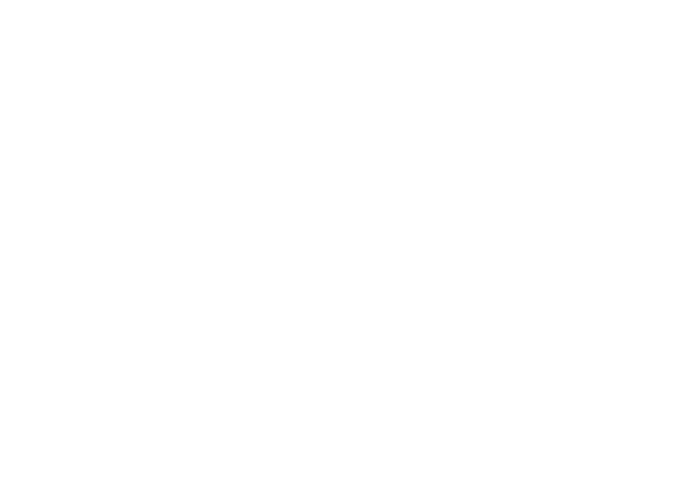

In [29]:
# Create animation
# basically will be a mat plot graph with highlighted text

%matplotlib widget

from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import random
import numpy as np
  
x = []
y = []
colors = []
fig = plt.figure(figsize=(7,5))
  
def animation_func(i):
    x.append(random.randint(0,100))
    y.append(random.randint(0,100))
    colors.append(np.random.rand(1))
    area = random.randint(0,30) * random.randint(0,30)
    plt.xlim(0,100)
    plt.ylim(0,100)
    plt.scatter(x, y, c = colors, s = area, alpha = 0.5)
  
animation = FuncAnimation(fig, animation_func, 
                          interval = 100)
plt.show()

In [11]:
# Write outputs to file
fout = open(out_path, 'a')
for (recov, ref, src) in zip(word_lst_recover, word_lst_ref, word_lst_source):
    print(json.dumps({"recover": recov, "reference": ref, "source": src}), file=fout)
fout.close()